In [1]:
!pip install -q langchain-google-genai langchain_huggingface langchain-groq langchain-text_splitters langchain-community langchain-tools langchain-core langchain ipywidgets pandas matplotlib langgraph

In [2]:
!pip install --upgrade langchain langchain-community

In [3]:
!pip install -q langchain-core

In [22]:
pip install -q langchain-classic


In [4]:
!pip install -q chromadb

In [5]:
!pip install -U langchain-voyageai


In [6]:
pip install -U langchain-cohere


In [25]:
from google.colab import userdata

LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')
COHERE_API_KEY = userdata.get('COHERE_API_KEY')
GROQ_API_KEY = userdata.get('GROQ_API_KEY')


In [26]:
import warnings

warnings.filterwarnings('ignore')

In [27]:
from langchain_cohere import CohereEmbeddings

embeddings = CohereEmbeddings(
    cohere_api_key=COHERE_API_KEY,
    model="embed-english-v3.0"
)

from langchain_groq import ChatGroq
llm=ChatGroq(model_name="llama-3.3-70b-versatile", api_key = GROQ_API_KEY)

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)

retriever = vectorstore.as_retriever()

In [28]:
from langchain_core.tools import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)


tools = [retriever_tool]

retriver grade


In [29]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [30]:
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [32]:
system = """You are a grader checking if a document is relevant to a user’s question.The check has to be done very strictly..
If the document has words or meanings related to the question, mark it as relevant.
Give a simple 'yes' or 'no' answer to show if the document is relevant or not."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [33]:
my_retrival_grader = grade_prompt | structured_llm_grader


In [34]:
question = "what is ai agent"
docs = retriever.invoke(question)

In [35]:
docs

[Document(metadata={'language': 'en', 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engi

In [36]:
doc_txt = docs[2].page_content
doc_txt

'Reliability of natural language interface: Current agent system relies on natural language as an interface between LLMs and external components such as memory and tools. However, the reliability of model outputs is questionable, as LLMs may make formatting errors and occasionally exhibit rebellious behavior (e.g. refuse to follow an instruction). Consequently, much of the agent demo code focuses on parsing model output.\n\n\nCitation#\nCited as:'

In [37]:
print(my_retrival_grader.invoke({"document": doc_txt, "question": question}))

binary_score='yes'


In [38]:
question = "who is prime minister of india"
print(my_retrival_grader.invoke({"document": doc_txt, "question": question}))

binary_score='no'


# Data Generation


In [42]:
### Generate

from langchain_classic import hub
from langchain_core.output_parsers import StrOutputParser
from pprint import pprint

prompt = hub.pull("rlm/rag-prompt")

prompt.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [43]:
rag_chain = prompt | llm

In [44]:
question="what is a AI agent?"

In [45]:
generation = rag_chain.invoke({"context": docs, "question": question})

In [46]:
generation

AIMessage(content='An AI agent is an autonomous system that uses a large language model (LLM) as its core controller, complemented by key components such as planning, memory, and tool use. The agent can break down complex tasks into smaller subgoals, learn from mistakes, and refine its actions to improve results. It can also leverage external APIs and memory to access additional information and capabilities.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 2010, 'total_tokens': 2087, 'completion_time': 0.229055135, 'completion_tokens_details': None, 'prompt_time': 0.118728272, 'prompt_tokens_details': None, 'queue_time': 0.008691965, 'total_time': 0.347783407}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_43d97c5965', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c2c04-eaa5-7a42-87d2-3b62de60d796-0', tool_calls=[], invalid_tool_calls=[], usage_me

# Halluciation Grader

In [47]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


In [48]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

In [49]:
# Prompt
system = """You are a grader checking if an LLM generation is grounded in or supported by a set of retrieved facts.
Give a simple 'yes' or 'no' answer. 'Yes' means the generation is grounded in or supported by a set of retrieved the facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)


In [50]:
hallucinations_grader = hallucination_prompt | structured_llm_grader

In [51]:
print(hallucinations_grader.invoke({"documents": docs, "generation": generation}))

binary_score='yes'


# Answer Grader

In [52]:
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
print(answer_grader.invoke({"question": question, "generation": generation}))

binary_score='yes'


# Question rewriter

In [63]:
system = """You are a question re-writer that converts an input question into a better optimized version for vector store retrieval document.
You are given both a question and a document.
- First, check if the question is relevant to the document by identifying a connection or relevance between them.
- If there is a little relevancy, rewrite the question based on the semantic intent of the question and the context of the document.
- If no relevance is found, simply return this single word "question not relevant." dont return the entire phrase
- reject domain also like software development or web dev question
Your goal is to ensure the rewritten question aligns well with the document for better retrieval."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human","""Here is the initial question: \n\n {question} \n,
             Here is the document: \n\n {documents} \n ,
             Formulate an improved question. if possible other return 'question not relevant'."""
        ),
    ]
)
question_rewriter = re_write_prompt | llm | StrOutputParser()


In [64]:
question="how write component in react"

question_rewriter.invoke({"question":question,"documents":docs})

'The initial question "how write component in react" is not relevant to the provided document, which discusses LLM-powered autonomous agents. The document does not mention React or component writing.\n\nTherefore, the response is: question not relevant.'

In [65]:
from typing import List
from typing_extensions import TypedDict
class AgentState(TypedDict):
    question: str
    generation: str
    documents: List[str]
    filter_documents: List[str]
    unfilter_documents: List[str]

In [81]:
def retrieve(state:AgentState):
    print("----RETRIEVE----")
    question=state['question']
    documents=retriever.invoke(question)
    return {"documents": documents, "question": question}

In [94]:
def grade_documents(state:AgentState):
    print("----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----")
    question = state['question']
    documents = state['documents']

    filtered_docs = []
    unfiltered_docs = []
    for doc in documents:
        score=my_retrival_grader.invoke({"question":question, "document":doc})
        grade=score.binary_score

        if grade=='yes':
            print("----GRADE: DOCUMENT RELEVANT----")
            filtered_docs.append(doc)
        else:
            print("----GRADE: DOCUMENT NOT RELEVANT----")
            unfiltered_docs.append(doc)
    if len(unfiltered_docs)>1:
        return {"unfilter_documents": unfiltered_docs,"filter_documents":[], "question": question}
    else:
        return {"filter_documents": filtered_docs,"unfilter_documents":[],"question": question}

In [95]:
def decide_to_generate(state:AgentState):
    print("----ACCESS GRADED DOCUMENTS----")
    state["question"]
    unfiltered_documents = state["unfilter_documents"]
    filtered_documents = state["filter_documents"]


    if unfiltered_documents:
        print("----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY----")
        return "transform_query"
    if filtered_documents:
        print("----DECISION: GENERATE----")
        return "generate"

In [96]:
def generate(state:AgentState):
    print("----GENERATE----")
    question=state["question"]
    documents=state["documents"]

    generation = rag_chain.invoke({"context": documents,"question":question})
    return {"documents":documents,"question":question,"generation":generation}

In [97]:
def transform_query(state:AgentState):
    question=state["question"]
    documents=state["documents"]

    print(f"this is my document{documents}")
    response = question_rewriter.invoke({"question":question,"documents":documents})
    print(f"----RESPONSE---- {response}")
    if response == 'question not relevant':
        print("----QUESTION IS NOT AT ALL RELEVANT----")
        return {"documents":documents,"question":response,"generation":"question was not at all relevant"}
    else:
        return {"documents":documents,"question":response}


In [98]:
def decide_to_generate_after_transformation(state:AgentState):
    question=state["question"]

    if question=="question not relevant":
        return "query_not_at_all_relevant"
    else:
        return "Retriever"

In [99]:
import pprint
def grade_generation_vs_documents_and_question(state:AgentState):
    print("---CHECK HELLUCINATIONS---")
    question= state['question']
    documents = state['documents']
    generation = state["generation"]

    score = hallucinations_grader.invoke({"documents":documents,"generation":generation})

    grade = score.binary_score

    #Check hallucinations
    if grade=='yes':
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")

        print("---GRADE GENERATION vs QUESTION ---")

        score = answer_grader.invoke({"question":question,"generation":generation})

        grade = score.binary_score

        if grade=='yes':
            print("---DECISION: GENERATION ADDRESS THE QUESTION ---")
            return "useful"
        else:
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
        "not useful"

# Langgraph Workflow

In [100]:
from langgraph.graph import END, StateGraph, START


from typing import List
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(AgentState)
workflow.add_node("Docs_Vector_Retrieve", retrieve)
workflow.add_node("Grading_Generated_Documents", grade_documents)
workflow.add_node("Content_Generator", generate)
workflow.add_node("Transform_User_Query", transform_query)



In [101]:
workflow.add_edge(START,"Docs_Vector_Retrieve")
workflow.add_edge("Docs_Vector_Retrieve","Grading_Generated_Documents")
workflow.add_conditional_edges("Grading_Generated_Documents",
                            decide_to_generate,
                            {
                            "generate": "Content_Generator",
                            "transform_query": "Transform_User_Query"
                            }
                            )
workflow.add_conditional_edges("Content_Generator",
                            grade_generation_vs_documents_and_question,
                            {
                            "useful": END,
                            "not useful": "Transform_User_Query",
                            }
                            )
workflow.add_conditional_edges("Transform_User_Query",
                decide_to_generate_after_transformation,
                {
                "Retriever":"Docs_Vector_Retrieve",
                "query_not_at_all_relevant":END
                }
                )

In [102]:
app=workflow.compile()

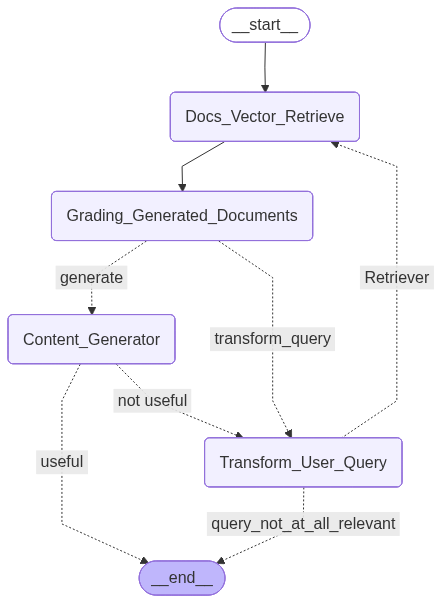

In [103]:
from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [104]:
inputs = {"question": "Explain how the different types of agent memory work?"}

In [105]:
app.invoke(inputs)["generation"]

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----DECISION: GENERATE----
----GENERATE----
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION ---
---DECISION: GENERATION ADDRESS THE QUESTION ---


AIMessage(content='There are two types of agent memory: short-term memory and long-term memory. Short-term memory utilizes in-context learning, where the model learns from the input prompt, while long-term memory retains and recalls information over extended periods using an external vector store and fast retrieval. The long-term memory allows the agent to learn from past experiences and refine its actions for future steps.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 1951, 'total_tokens': 2025, 'completion_time': 0.213448956, 'completion_tokens_details': None, 'prompt_time': 0.10921778, 'prompt_tokens_details': None, 'queue_time': 0.039048179, 'total_time': 0.322666736}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_bebe2dd4fb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c2c33-099a-7771-9614-9756908ce627-0', tool_calls=[], invalid_tool_cal